<img style="float: center;" src="../support/images/CI_horizontal.png" width="400">

https://coleridgeinitiative.org/

## Test clustering options

test clustering options to potentially be built in to dashboard:
- k-means clustering
- agglomerative clustering
- spatially constrained clustering ([workbook example from darribas.org/gds_scipy16](http://darribas.org/gds_scipy16/ipynb_md/07_spatial_clustering.html
  - MaxP Regionalization ([function documentation](http://pysal.readthedocs.io/en/latest/library/region/maxp.html))


In [1]:
# initial libraries
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd
import pysal as ps
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import *

%matplotlib notebook

## set DB connection and define functions to get data

In [2]:
######## 1. Database connection #################
DB = 'datadb'
USER = 'clayton'
HOST = 'localhost'
PORT = '5432'
PW = 'clayton'

DB_CONNECTION_STRING = 'postgresql://{username}:{password}@{host}:{port}/{database}'.format(
username=USER, password=PW, host=HOST, port=PORT, database=DB)

engine = create_engine(DB_CONNECTION_STRING)

######## 2. functions to get data ###################
# function to get data - cbsafp = '28140' is KCMO metro area
# returns the base, Block level data
def getWAC(seg='s000', jt='jt01', years=xrange(2002,2016), cbsafp = '28140'):
    # to pull data from database
    DFs = []
    # get data
    for year in years:
        qry = """
        SELECT *, left(w_geocode, 5) countyfp, {YR} AS year 
        FROM lodes.mo_wac_{SEG}_{JT}_{YR}
        WHERE left(w_geocode, 5) 
        IN (SELECT geoid FROM tl_2016_us_county WHERE cbsafp = '{CBSA}')
        """.format(SEG=seg, JT=jt, YR=year, CBSA=cbsafp)
        df = pd.read_sql(qry, engine)
#         df.drop(columns='createdate', inplace=True)
#         df['year'] = year
        DFs.append(df)
    # combine DFs into single dataframe
    df = pd.concat(DFs)
    return(df)

# get geographic data
# functions return pandas.DataFrame objects based on the counties in a given CBSA 

def _counties(cbsafp='28140', crs='102698'):
    # get counties
    qry = """
    SELECT geoid, name,
        ST_Transform(geom, {CRS}) geom 
    FROM tl_2016_us_county 
    WHERE cbsafp = '{CBSA}'
    """.format(CBSA=cbsafp, CRS=crs)

    counties = gpd.read_postgis(qry, engine, geom_col='geom')
    counties['coords'] = counties.geometry.apply(lambda x: x.representative_point().coords[0])
    return(counties)

def _blkgrps(cbsafp='28140', crs='102698'):
    # get BlockGroups for map

    qry = """
    SELECT blockgroup,
        ST_Transform(geom, {CRS}) geom 
    FROM tl_2016_29_blkgrp
    WHERE left(blockgroup, 5) 
        IN (SELECT geoid
            FROM tl_2016_us_county 
            WHERE cbsafp =  '{CBSA}')
    """.format(CBSA='28140', CRS=crs)

    blkgrps = gpd.read_postgis(qry, engine, geom_col='geom')
    blkgrps['coords'] = blkgrps.geometry.apply(lambda x: x.representative_point().coords[0])
    return(blkgrps)


# def get_geogs(geos = ['counties', 'blockgroups'], cbsafp='28140', crs='102698'):
#     # hold retrieved data:
#     GDFs = {}
#     # get data for each of the geos passed:
#     for g in geos:
#         GDFs[g] = geoFunc[g]
#     return(GDFs)


In [ ]:
# create weights file for
ps.weights.Rook.from_dataframe()

## Clustering WAC data

In [3]:
# get data
df = getWAC(years=range(2004, 2015))
df.describe().T

,count,mean,std,min,25%,50%,75%,max
c000,106043.0,51.670898,189.399643,0.0,2.0,8.0,33.0,8169.0
ca01,106043.0,12.906010,44.693508,0.0,0.0,2.0,8.0,1971.0
ca02,106043.0,29.205011,117.114729,0.0,1.0,4.0,17.0,5114.0
ca03,106043.0,9.559877,38.135175,0.0,0.0,1.0,6.0,2336.0
ce01,106043.0,11.341296,33.660698,0.0,0.0,2.0,8.0,1324.0
ce02,106043.0,20.344275,71.879836,0.0,1.0,3.0,13.0,3783.0
ce03,106043.0,19.985327,111.956365,0.0,0.0,2.0,8.0,5152.0
cns01,106043.0,0.090869,1.438544,0.0,0.0,0.0,0.0,131.0
cns02,106043.0,0.040455,1.000040,0.0,0.0,0.0,0.0,74.0
cns03,106043.0,0.447366,11.333489,0.0,0.0,0.0,0.0,810.0


In [4]:
# import clustering algorithms from sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [5]:
# columns to use
starts_with = ('ca', 'ce', 'cns')

# column selection list
sel_columns = [col for col in df.columns.tolist() if col.startswith(starts_with)]
print(sel_columns)

[u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01', u'cns02', u'cns03', u'cns04', u'cns05', u'cns06', u'cns07', u'cns08', u'cns09', u'cns10', u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17', u'cns18', u'cns19', u'cns20']


In [6]:
# get blockgroup from block
df['blkgrp'] = df['w_geocode'].apply(lambda g: g[:12])

In [7]:
df_to_cluster = df.groupby('blkgrp')[sel_columns].sum()

### KMeans clustering

In [8]:
# test cluster sizes from 3-9
cluster_sizes = range(3,10,1)

cluster_stats = {}

for k in cluster_sizes:
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit(df_to_cluster[sel_columns].values)
    new_col = 'k_'+str(k)
    df_to_cluster[new_col] = clusters.labels_
    
    # print out summary of clusters
    print('KMeans with {} groups'.format(k))
    cluster_means  = df_to_cluster.groupby(new_col)[sel_columns].mean()
    cluster_stats[new_col] = df_to_cluster.groupby(new_col)[sel_columns].agg({'mean': pd.np.mean, 
                                                                              'median': pd.np.median, 
                                                                              'min': min, 'max': max})
#     print(cluster_means.T)
#     print(df_to_cluster.groupby(new_col)[sel_columns].agg({'mean': pd.np.mean, 'median': pd.np.median, 
#                                                            'min': min, 'max': max}))


KMeans with 3 groups
KMeans with 4 groups
KMeans with 5 groups
KMeans with 6 groups
KMeans with 7 groups


/Users/crh278/anaconda3/envs/ada-env/lib/python2.7/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KMeans with 8 groups
KMeans with 9 groups


In [9]:
cluster_stats['k_5'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Columns: 104 entries, (max, ca01) to (mean, cns20)
dtypes: float64(52), int64(52)
memory usage: 4.1 KB


In [10]:
cluster_stats['k_5'].columns.get_level_values(1)

Index([u'ca01', u'ca02', u'ca03', u'ce01', u'ce02', u'ce03', u'cns01',
       u'cns02', u'cns03', u'cns04',
       ...
       u'cns11', u'cns12', u'cns13', u'cns14', u'cns15', u'cns16', u'cns17',
       u'cns18', u'cns19', u'cns20'],
      dtype='object', length=104)

In [11]:
inc_cols = [col for col in sel_columns if col.startswith('ce')]

In [12]:
idx = pd.IndexSlice
cluster_stats['k_5'].loc[:, idx['median', inc_cols]]

median                  
        ce01     ce02     ce03
k_5                           
0      404.0    623.0    403.0
1    11784.0  44508.0  68743.5
2     5796.5  15724.0  19403.0
3    16697.0  64683.5  65328.5
4     3259.5   5170.0   4299.0

In [13]:
cluster_stats_melt = {}

for k, v in cluster_stats.iteritems():
    
    cluster_stats_melt[k] = pd.melt(v)
    cluster_stats_melt[k].rename(columns={'variable_0': 'stat', 'variable_1': 'category'}, inplace=True)
#     cluster_stats_melt.head()

In [14]:
cluster_stats_melt['k_7'].head()

,stat,category,value
0,max,ca01,3941.0
1,max,ca01,28454.0
2,max,ca01,26146.0
3,max,ca01,9931.0
4,max,ca01,27993.0


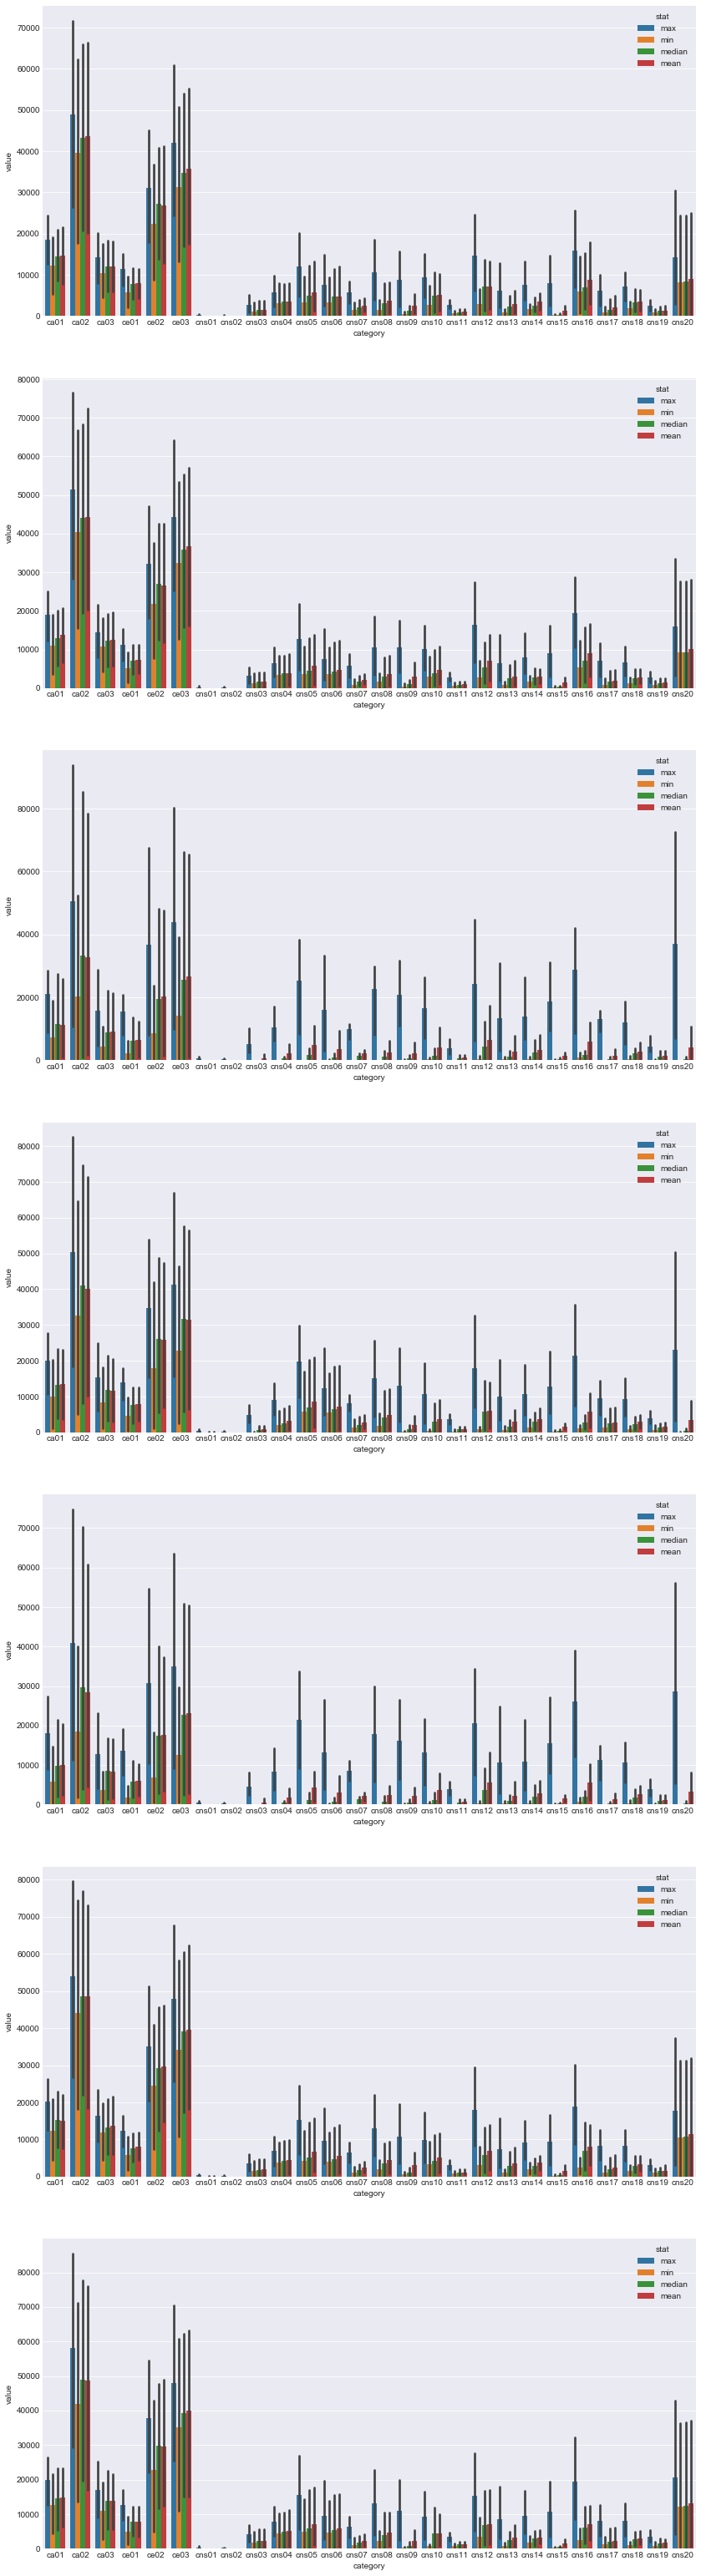

In [18]:
# compare cluster stats, eg for income levels
sns.set_style('darkgrid')

num_clusters = len(cluster_stats_melt.keys())

f, axes = plt.subplots(num_clusters, figsize=(14,8*num_clusters))
i = 0

for k, v in cluster_stats_melt.iteritems():
#     v = v.loc[:,idx[:, inc_cols]]
#     print(k)
    sns.barplot(x='category', y='value', hue='stat', data=v, ax=axes[i])
#     plt.show()
    i += 1 # iterate for next axis